In [1]:
import networkx as nx
import torch
import torch_geometric
import numpy as np
import matplotlib.pyplot as plt
import tqdm.notebook

In [2]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

In [3]:
def beta_func(t):
    """
    Maps a tensor of times `t` to particular noise levels beta.
    Arguments:
        `t`: a tensor of times
    Returns an equivalently shaped tensor of beta values.
    """
    return torch.sigmoid((t / 6) - 8)


def beta_bar_func(t):
    """
    Maps a tensor of times `t` to beta-bar values. If each beta is a probability
    of a flip at some particular time, then beta-bar is the probability of a
    flip from 0 until this `t`.
    Arguments:
        `t`: a B-tensor of times
    Returns a B-tensor of beta-bar values.
    """
    max_range = torch.arange(1, torch.max(t) + 1, device=DEVICE)
    betas = beta_func(max_range)  # Shape: maxT

    betas_tiled = torch.tile(betas, (t.shape[0], 1))  # Shape: B x maxT
    biases = 0.5 - betas_tiled

    # Anything that ran over a time t, set to 1
    mask = max_range[None] > t[:, None]
    biases[mask] = 1

    prod = torch.prod(biases, dim=1)
    return 0.5 - (torch.pow(2, t - 1) * prod)

In [4]:
def _inflate_dims(v, num_dims):
    """
    Given a tensor vector `v`, appends dimensions of size 1 so that
    it has `num_dims` dimensions. Forexample, if `num_dims` is 3,
    this turns `v` from a B-tensor to a B x 1 x 1 tensor.
    Arguments:
        `v`: a B-tensor
        `num_dims`: an integer greater than 1
    Returns a B x ... tensor of dimension `num_dims`.
    """
    return v[(slice(None),) + ((None,) * (num_dims - 1))]

In [5]:
def noise_input(x0, t):
    """
    Given a binary input at time 0, return a version of the input that
    has noise added to it at time `t` based on random bit flips.
    Arguments:
        `x0`: a binary B x ... tensor of bits at time 0
        `t`: time to add noise to, a B-tensor
    Returns a new binary B x ... tensor, and leaves the originals untouched.
    """
    prob_flip = torch.tile(
        _inflate_dims(beta_bar_func(t), len(x0.shape)), (1, *x0.shape[1:])
    )
    
    flip_indicators = torch.bernoulli(prob_flip)

    # Perform flips
    xt = x0.clone()
    mask = flip_indicators == 1
    xt[mask] = 1 - x0[mask]

    return xt

In [6]:
def posterior_prob(x0, xt, t):
    """
    Compute the probability of an bit at time t - 1, given the bits at time 0
    and t.
    Arguments:
        `x0`: a binary B x ... tensor at time 0
        `xt`: a binary B x ... tensor at time t
        `t`: B-tensor of times
    Returns a B x ... tensor of probabilities that a bit would be 1 at time
    t - 1.
    """
    beta_t = _inflate_dims(beta_func(t), len(x0.shape))
    beta_bar_t = _inflate_dims(beta_bar_func(t), len(x0.shape))
    beta_bar_t_1 = _inflate_dims(beta_bar_func(t - 1), len(x0.shape))

    term_1 = ((1 - xt) * beta_t) + (xt * (1 - beta_t))
    term_2 = ((1 - x0) * beta_bar_t_1) + (x0 * (1 - beta_bar_t_1))
    x0_xor_xt = torch.square(x0 - xt)
    term_3 = (x0_xor_xt * beta_bar_t) + ((1 - x0_xor_xt) * (1 - beta_bar_t))

    return term_1 * term_2 / term_3

In [7]:
def get_nx_edges(graph):
    """
    Returns a binary E-array of the edges in a NetworkX graph in
    canonical order. Note that self-edges are not allowed.
    Arguments:
        `graph`: a NetworkX graph
    """
    num_nodes = graph.number_of_nodes()
    return nx.to_numpy_array(graph)[np.triu_indices(num_nodes, k=1)]

def set_nx_edges(graph, edges):
    """
    Sets the edges in the adjacency matrix of a NetworkX graph
    according to the given edges. Note that self-edges are not allowed.
    Arguments:
        `graph`: a NetworkX graph
        `edges`: a binary E-array of edges in canonical order
    """
    num_nodes = graph.number_of_nodes()
    assert len(edges) == (num_nodes * (num_nodes - 1)) // 2

    edges_to_set = np.stack(np.triu_indices(num_nodes, k=1), axis=1)[edges == 1]

    graph.clear_edges()

    for u, v in edges_to_set:
        graph.add_edge(u, v)

def get_nx_node_features(graph):
    """
    Returns a V x D array of the node features of a NetworkX graph
    in canonical order.  
    Arguments:
        `graph`: a NetworkX graph
    """
    feat_dict = nx.get_node_attributes(graph, "feats")
    return np.vstack([feat_dict[i] for i in range(graph.number_of_nodes())])

def set_nx_node_features(graph, feats):
    """
    Sets the node features in the NetworkX graph to the given array.
    Arguments:
        `graph`: a NetworkX graph
        `feats`: a V x D array of node features in canonical order
    """
    feat_dict = {i : feats[i] for i in range(graph.number_of_nodes())}
    nx.set_node_attributes(graph, feat_dict, "feats")

In [8]:
def pyg_data_to_edge_vector(data):
    """
    Returns a binary E-tensor of the edges from a torch-geometric Data
    object in canonical order. Note that self-edges are not allowed.
    Arguments:
        `data`: a torch-geometric Data object
    """
    # First, get (padded) adjacency matrix of size B x V x V, where V is
    # the maximum number of nodes in any individual graph
    adj_matrix = torch_geometric.utils.to_dense_adj(data.edge_index, data.batch)
    
    # Create boolean mask of only the top upper triangle of each B x V x V
    # matrix, ignoring the diagonal
    triu_mask = torch.triu(torch.ones_like(adj_matrix), diagonal=1) == 1
    for i, size in enumerate(torch.diff(data.ptr)):
        # TODO: make this more efficient
        # For each individual graph, limit the upper-triangle mask to
        # only the size of that graph
        triu_mask[i, :, size:] = False
        
    # Return all entries in the graph-specific upper triangle of each
    # individual adjacency matrix
    return adj_matrix[triu_mask]

def edge_vector_to_pyg_data(data, edges, reflect=True):
    """
    Returns the edge-index tensor which would be associated with the
    torch-geometric Data object `data`, if the edges in the edge index
    attribute were set according to the given edges. Note that self-edges
    are not allowed. If `edges` is a scalar 1, then this returns the set
    of all edges as an edge-index tensor
    Arguments:
        `data`: a torch-geometric Data object
        `edges`: a binary E-tensor of edges in canonical order, or the
            scalar 1
        `reflect`: by default, each edge will be represented twice in the
            edge-index tensor (no self-edges are allowed); if False, only
            the upper-triangular indices will be present (and thus the
            tensor's size will be halved)
    Returns a 2 x E' edge-index tensor.
    """
    graph_sizes = torch.diff(data.ptr)
    max_size = torch.max(graph_sizes)
    
    # Create filler adjacency matrix that starts out as all 0s
    adj_matrix = torch.zeros(graph_sizes.shape[0], max_size, max_size, device=DEVICE)
    
    # Create boolean mask of only the top upper triangle of each B x V x V
    # matrix, ignoring the diagonal
    triu_mask = torch.triu(torch.ones_like(adj_matrix), diagonal=1) == 1
    for i, size in enumerate(torch.diff(data.ptr)):
        # TODO: make this more efficient
        # For each individual graph, limit the upper-triangle mask to
        # only the size of that graph
        triu_mask[i, :, size:] = False
        
    # Set the upper triangle of each graph-specific adjacency matrix to
    # the edges given,
    adj_matrix[triu_mask] = edges
    
    # Symmetrize the matrix
    if reflect:
        adj_matrix = adj_matrix + torch.transpose(adj_matrix, 1, 2)
    
    # Get indices where the adjacency matrix is nonzero (an E x 3 matrix)
    nonzero_inds = adj_matrix.nonzero()
    
    # The indices are for each individual graph, so add the graph-size
    # pointers to each set of indices so later graphs have higher
    # indices based on the sizes of earlier graphs
    edges_to_set = nonzero_inds[:, 1:] + data.ptr[nonzero_inds[:, 0]][:, None]
    
    # Convert to a 2 x E matrix
    edges_to_set = edges_to_set.t().contiguous()
    return torch_geometric.utils.sort_edge_index(edges_to_set)

In [9]:
def split_pyg_data_to_nx_graphs(data):
    graphs = []
    pointers = data.ptr.cpu().numpy()
    graph_sizes = np.diff(pointers)
    num_graphs = len(graph_sizes)

    # First, get (padded) adjacency matrix of size B x V x V, where V is
    # the maximum number of nodes in any individual graph
    adj_matrix = torch_geometric.utils.to_dense_adj(data.edge_index, data.batch)

    for i in range(num_graphs):
        graph = nx.empty_graph(graph_sizes[i])
        
        # Get the indices of adjacency matrix, upper triangle only
        edge_indices = torch.triu(adj_matrix[i], diagonal=1).nonzero().cpu().numpy()
        for u, v in edge_indices:
            graph.add_edge(u, v)

        node_feats = data.x[pointers[i] : pointers[i + 1]].cpu().numpy()
        feat_dict = {i : node_feats[i] for i in range(graph.number_of_nodes())}
        nx.set_node_attributes(graph, feat_dict, "feats")

        graphs.append(graph)
    return graphs

In [10]:
def create_random_tree(num_nodes, node_dim):
    """
    Creates a random connected tree. The node attributes will be initialized
    by a random vector plus some noisy distance from a randomly selected
    source node.
    Arguments:
        `num_nodes`: number of nodes in the graph
        `node_dim`: size of node feature vector
    Returns a NetworkX Graph with NumPy arrays as node attributes.
    """
    g = nx.random_tree(num_nodes)

    node_features = np.empty((num_nodes, node_dim))
    
    # Pick a random source node
    source = np.random.choice(num_nodes)
    
    # Set source node's feature to random vector
    source_feat = np.random.randn(node_dim) * np.sqrt(num_nodes)
    node_features[source] = source_feat
    
    # Run BFS starting from source node; for each layer, set features
    # to be the source vector plus the distance plus noise
    current_layer = [source]
    distance = 1
    visited = set(current_layer)
    while current_layer:
        next_layer = []
        for node in current_layer:
            for child in g[node]:
                if child not in visited:
                    visited.add(child)
                    next_layer.append(child)
                    node_features[child] = source_feat + distance + np.random.randn(node_dim)
        current_layer = next_layer
        distance += 1

    nx.set_node_attributes(g, {i : node_features[i] for i in range(num_nodes)}, "feats")
    return g

In [11]:
class RandomTreeDataset(torch.utils.data.Dataset):
    def __init__(self, num_nodes, node_dim, num_items=1000):
        """
        Create a PyTorch IterableDataset which yields random trees.
        Arguments:
            `num_nodes`: number of nodes in the graph; can be an
                integer or a NumPy array of integers to sample from
                uniformly
            `node_dim`: size of node feature vector
            `num_items`: number of items to yield in an epoch
        """
        super().__init__()
        
        if type(num_nodes) is int:
            num_nodes = np.array([num_nodes])
            
        self.num_nodes = num_nodes
        self.node_dim = node_dim
        self.num_items = num_items

    def __getitem__(self, index):
        """
        Returns a single data point generated randomly, as a
        torch-geometric Data object. `index` is ignored.
        """
        num_nodes = np.random.choice(self.num_nodes)
        graph = create_random_tree(num_nodes, self.node_dim)
        data = torch_geometric.utils.from_networkx(
            graph, group_node_attrs=["feats"]
        )
        data.edge_index = torch_geometric.utils.sort_edge_index(data.edge_index)
        return data.to(DEVICE)

    def __len__(self):
        return self.num_items

In [12]:
class GraphLinkPredictor(torch.nn.Module):

    def __init__(
        self, input_dim, num_gnn_layers=4, hidden_dim=10, time_embed_size=256
    ):
        """
        Initialize a time-dependent GNN which predicts bit probabilities for
        each edge.
        Arguments:
            `input_dim`: the dimension of the input node features
            `num_gnn_layers`: number of GNN layers to have
            `hidden_dim`: the dimension of the hidden node embeddings
            `time_embed_size`: size of the time embeddings
        """
        super().__init__()
        
        self.num_gnn_layers = num_gnn_layers
                
        # Random embedding layer for time; the random weights are set at the
        # start and are not trainable
        self.time_embed_rand_weights = torch.nn.Parameter(
            torch.randn(time_embed_size // 2) * 30, requires_grad=False
        )
        self.time_embed_dense = torch.nn.Linear(time_embed_size, time_embed_size)
        
        self.swish = lambda x: x * torch.sigmoid(x)
        self.relu = torch.nn.ReLU()
        
        # GNN layers
        self.gnn_layers = torch.nn.ModuleList()
        self.gnn_batch_norms = torch.nn.ModuleList()
        for i in range(num_gnn_layers):
            gnn_nn = torch.nn.Sequential(
                torch.nn.Linear(
                    input_dim + time_embed_size if i == 0 else hidden_dim,
                    hidden_dim * 2
                ),
                torch.nn.BatchNorm1d(hidden_dim * 2),
                self.relu,
                torch.nn.Linear(hidden_dim * 2, hidden_dim)
            )
            gnn_layer = torch_geometric.nn.GINConv(gnn_nn, train_eps=True) 
            gnn_batch_norm = torch.nn.BatchNorm1d(hidden_dim)

            self.gnn_layers.append(gnn_layer)
            self.gnn_batch_norms.append(gnn_batch_norm)
            
        # Link prediction
        self.link_dense = torch.nn.Linear(hidden_dim, 1)
        
    def forward(self, data, t):
        """
        Forward pass of the network.
        Arguments:
            `data`: a (batched) torch-geometric Data object
            `t`: 1-tensor containing the time to train on
        Returns an E-tensor of probabilities of each edge at time t - 1,
        where E is the total possible number of edges, and is in canonical
        ordering.
        """
        # Get the time embeddings for `t`
        # We first sample vector z from some zero-mean Gaussian (of fixed variance),
        # and then we embed the time as cos(2 * pi * t * z) and sin(2 * pi * t * z)
        time_embed_args = t[:, None] * self.time_embed_rand_weights[None, :] * 2 * np.pi
        # Shape: 1 x (D / 2)
        time_embed = self.swish(self.time_embed_dense(
                torch.cat([torch.sin(time_embed_args), torch.cos(time_embed_args)], dim=1)
        ))
        # Shape: 1 x D
        
        # GNN layers
        node_embed = data.x.float()
        num_nodes = node_embed.shape[0]
        time_embed_tiled = torch.tile(time_embed, (num_nodes, 1))  # Shape: V x D
        node_embed = torch.cat([node_embed, time_embed_tiled], dim=1)
        for i in range(self.num_gnn_layers - 1):
            node_embed = self.relu(
                self.gnn_batch_norms[i](
                    self.gnn_layers[i](node_embed, data.edge_index)
                )
            )
        node_embed = self.gnn_batch_norms[-1](
            self.gnn_layers[-1](node_embed, data.edge_index)
        )  # Last layer without ReLU
            
        # For all possible edges (i.e. node pairs), compute probability
        edge_inds = edge_vector_to_pyg_data(data, 1, reflect=False)  # Shape: 2 x E
        node_embed_1 = node_embed[edge_inds[0]]  # Shape: E x D'
        node_embed_2 = node_embed[edge_inds[1]]  # Shape: E x D'
        node_prod = node_embed_1 * node_embed_2
        
        edge_probs = torch.sigmoid(self.link_dense(node_prod))[:, 0]
        
        return edge_probs

    def loss(self, pred_probs, true_probs):
        """
        Computes the loss of a batch.
        Arguments:
            `pred_probs`: an E-tensor of predicted probabilities
            `true_probs`: an E-tensor of true probabilities
        Returns a scalar loss value.
        """
        return torch.nanmean(
            (true_probs * torch.log(true_probs / pred_probs)) +
            ((1 - true_probs) * torch.log((1 - true_probs) / (1 - pred_probs)))
        )

In [13]:
def train_model(model, data_loader, t_limit, num_epochs, learning_rate):
    """
    Trains a ProbGraphEdge model.
    Arguments:
        `model`: an initialized GraphLinkPredictor model
        `data_loader`: a DataLoader which iterates over batches of
            random graphs as `torch_geometric` Data objects
        `t_limit`: maximum time range for noising
        `num_epochs`: number of epochs to train for
        `learning_rate`: learning rate to use for training
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model.train()
    torch.set_grad_enabled(True)

    for epoch_num in range(num_epochs):
        losses = []
        t_iter = tqdm.notebook.tqdm(
            data_loader, total=len(data_loader), desc="Loss: -----"
        )

        for data in t_iter:
            # Pick some random time t between 1 and t_limit (inclusive)
            t = torch.randint(t_limit, size=(1,), device=DEVICE) + 1

            # Add noise to edges from time 0 to time t
            e0 = pyg_data_to_edge_vector(data)
            et = noise_input(e0[None], t)[0]  # Do the noising on 1 x E tensors
            data.edge_index = edge_vector_to_pyg_data(data, et)  # Note: this modifies `data`

            # Compute posterior probability of bits
            true_probs = posterior_prob(e0, et, t)

            # Have model try and predict posterior probability
            pred_probs = model(data, t)

            loss = model.loss(pred_probs, true_probs)
            
            if not np.isfinite(loss.item()):
                continue
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            t_iter.set_description(
                "Loss: %6.5f" % loss.item()
            )
            losses.append(loss.item())

        print("Epoch %d average loss: %.5f" % (epoch_num + 1, np.mean(losses)))
        torch.save(model.state_dict(), "ckpt.pth")

Expected cycles in limit: 562.99
Expected edges in limit: 611.99


/gstore/home/tsenga5/miniconda3/envs/graph-diff/lib/python3.8/site-packages/torch_geometric/utils/convert.py:192: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/torch/csrc/utils/tensor_new.cpp:210.)
  data[key] = torch.tensor(value)


  0%|          | 0/49 [00:00<?, ?it/s]

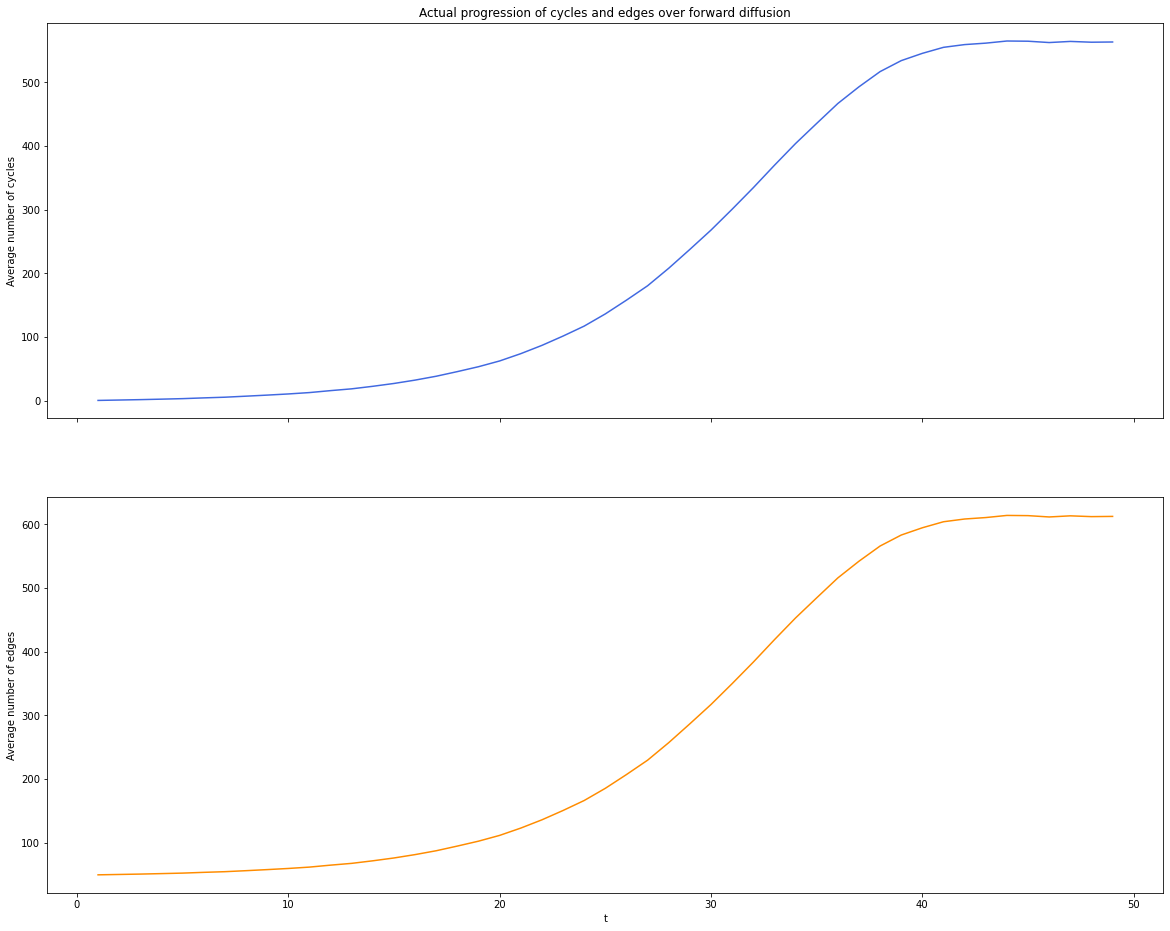

In [14]:
# Check progression of the number of cycles and edges

num_nodes, node_dim = 50, 5  # Fix 50 nodes for now
t_limit = 50
dataset = RandomTreeDataset(num_nodes, node_dim, num_items=500)
data_loader = torch_geometric.loader.DataLoader(
    dataset, batch_size=500
)

er_num_cycles, er_num_edges = [], []
for _ in range(500):
    er_graph = nx.erdos_renyi_graph(num_nodes, 0.5)
    er_num_cycles.append(len(nx.cycle_basis(er_graph)))
    er_num_edges.append(nx.number_of_edges(er_graph))

print("Expected cycles in limit: %.2f" % np.mean(er_num_cycles))
print("Expected edges in limit: %.2f" % np.mean(er_num_edges))

t_vals = np.arange(1, t_limit)
num_cycles = np.empty((len(t_vals), data_loader.batch_size))
num_edges = np.empty((len(t_vals), data_loader.batch_size))
data = next(iter(data_loader))
e0 = pyg_data_to_edge_vector(data)
for i, t in tqdm.notebook.tqdm(enumerate(t_vals), total=len(t_vals)):
    t_tens = torch.tensor([t], device=DEVICE)
    et = noise_input(e0[None], t_tens)[0]  # Do the noising on 1 x E tensors
    data.edge_index = edge_vector_to_pyg_data(data, et)  # Note: this modifies `data`
    
    # Convert to a list of NetworkX graphs
    graphs = split_pyg_data_to_nx_graphs(data)
    for j, g in enumerate(graphs):
        num_cycles[i, j] = len(nx.cycle_basis(g))
        num_edges[i, j] = nx.number_of_edges(g)

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(20, 16))
ax[0].plot(t_vals, np.mean(num_cycles, axis=1), color="royalblue")
ax[0].set_ylabel("Average number of cycles")

ax[1].plot(t_vals, np.mean(num_edges, axis=1), color="darkorange")
ax[1].set_ylabel("Average number of edges")
ax[1].set_xlabel("t")

ax[0].set_title("Actual progression of cycles and edges over forward diffusion")
plt.show()

  0%|          | 0/49 [00:00<?, ?it/s]

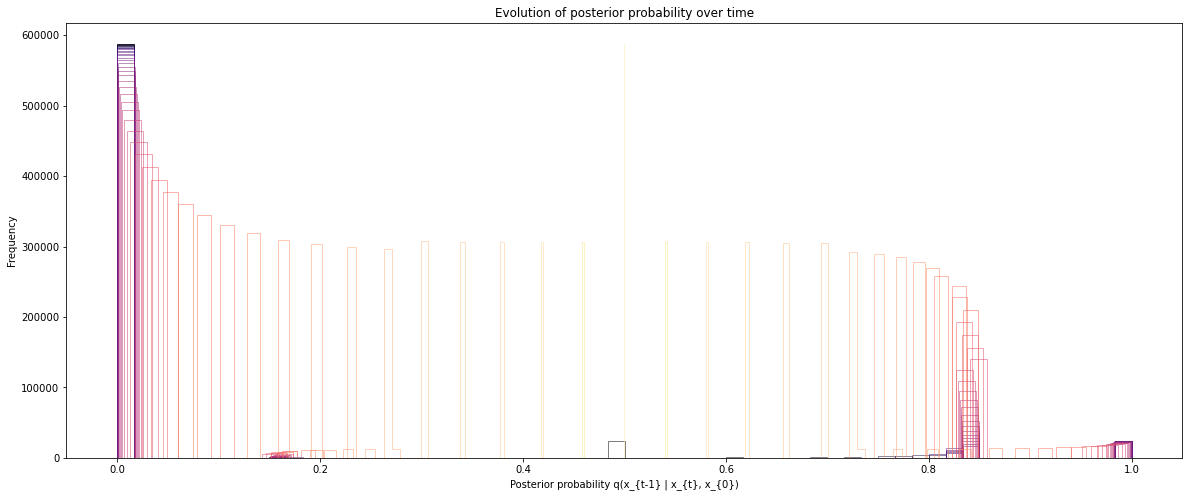

In [15]:
# Check progression of posterior probability
t_vals = np.arange(1, t_limit)
data = next(iter(data_loader))
e0 = pyg_data_to_edge_vector(data)
posterior_probs = np.empty((len(t_vals), e0.shape[0]))
for i, t in tqdm.notebook.tqdm(enumerate(t_vals), total=len(t_vals)):
    t_tens = torch.tensor([t], device=DEVICE)
    et = noise_input(e0[None], t_tens)[0]  # Do the noising on 1 x E tensors
    posterior_probs[i] = posterior_prob(e0, et, t_tens).cpu().numpy()
    
posterior_probs = np.clip(posterior_probs, 0, 1)
    
fig, ax = plt.subplots(figsize=(20, 8))
times = np.tile(t_vals[:, None], (1, posterior_probs.shape[1]))
cmap = plt.get_cmap("magma")
for t_i in range(len(t_vals)):
    ax.hist(posterior_probs[t_i], bins=60, histtype="step", color=cmap(t_i / len(t_vals)), alpha=0.5)
ax.set_xlabel("Posterior probability q(x_{t-1} | x_{t}, x_{0})")
ax.set_ylabel("Frequency")
ax.set_title("Evolution of posterior probability over time")
plt.show()

In [16]:
# Create the data loader for training
num_nodes, node_dim = np.arange(10, 50 + 1), 5
t_limit = 50

dataset = RandomTreeDataset(num_nodes, node_dim, num_items=6400)
data_loader = torch_geometric.loader.DataLoader(
    dataset, batch_size=32, shuffle=False, num_workers=0  # TODO: allow multi-processing
)

In [17]:
# Sanity-check the canonical ordering of edges from torch-geometric Data
data = next(iter(data_loader))

edge_indices = ["%d-%d" % (a, b) for a, b in data.edge_index.t().cpu().numpy()]
edges = pyg_data_to_edge_vector(data).cpu().numpy()
all_edge_indices = edge_vector_to_pyg_data(data, 1, reflect=False).t().cpu().numpy()

assert np.sum(edges) == len(edge_indices) / 2
for i, (a, b) in tqdm.notebook.tqdm(enumerate(all_edge_indices), total=len(all_edge_indices)):
    e1, e2 = "%d-%d" % (a, b), "%d-%d" % (b, a)
    if edges[i] == 0:
        assert e1 not in edge_indices and e2 not in edge_indices
    else:
        assert e1 in edge_indices and e2 in edge_indices

  0%|          | 0/13986 [00:00<?, ?it/s]

In [18]:
# Create and train the model
model = GraphLinkPredictor(node_dim).to(DEVICE)
train_model(
    model, data_loader,
    t_limit=t_limit,
    num_epochs=20,
    learning_rate=0.001
)

Loss: -----:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1 average loss: 0.40252


Loss: -----:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 2 average loss: 0.34144


Loss: -----:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 3 average loss: 0.34003


Loss: -----:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 4 average loss: 0.33205


Loss: -----:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 5 average loss: 0.31894


Loss: -----:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 6 average loss: 0.30764


Loss: -----:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 7 average loss: 0.30335


Loss: -----:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 8 average loss: 0.28892


Loss: -----:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 9 average loss: 0.28249


Loss: -----:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 10 average loss: 0.27902


Loss: -----:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 11 average loss: 0.27445


Loss: -----:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 12 average loss: 0.26318


Loss: -----:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 13 average loss: 0.25075


Loss: -----:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 14 average loss: 0.25417


Loss: -----:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 15 average loss: 0.25206


Loss: -----:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 16 average loss: 0.24496


Loss: -----:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 17 average loss: 0.25082


Loss: -----:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 18 average loss: 0.24041


Loss: -----:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 19 average loss: 0.23532


Loss: -----:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 20 average loss: 0.23434


In [19]:
# Take the trained model and go backwards to sample some graphs
print("Sampling some reverse trajectories")

graphs = []  # List of NetworkX graphs generated through time

# For simplicity, get a data batch and just run the forward
# diffusion process to sample
data = next(iter(data_loader))
e0 = pyg_data_to_edge_vector(data)
t_tens = torch.tensor([t_limit], device=DEVICE)
et = noise_input(e0[None], t_tens)[0]  # Do the noising on 1 x E tensors
data.edge_index = edge_vector_to_pyg_data(data, et)
graphs.append(split_pyg_data_to_nx_graphs(data))

for t in tqdm.notebook.trange(t_limit - 1, 0, -1):
    edge_probs = model(
        data, torch.tensor([t_limit], device=DEVICE)
    )
    edges = torch.bernoulli(edge_probs)
    data.edge_index = edge_vector_to_pyg_data(data, edges)
    graphs.append(split_pyg_data_to_nx_graphs(data))

Sampling some reverse trajectories


  0%|          | 0/49 [00:00<?, ?it/s]

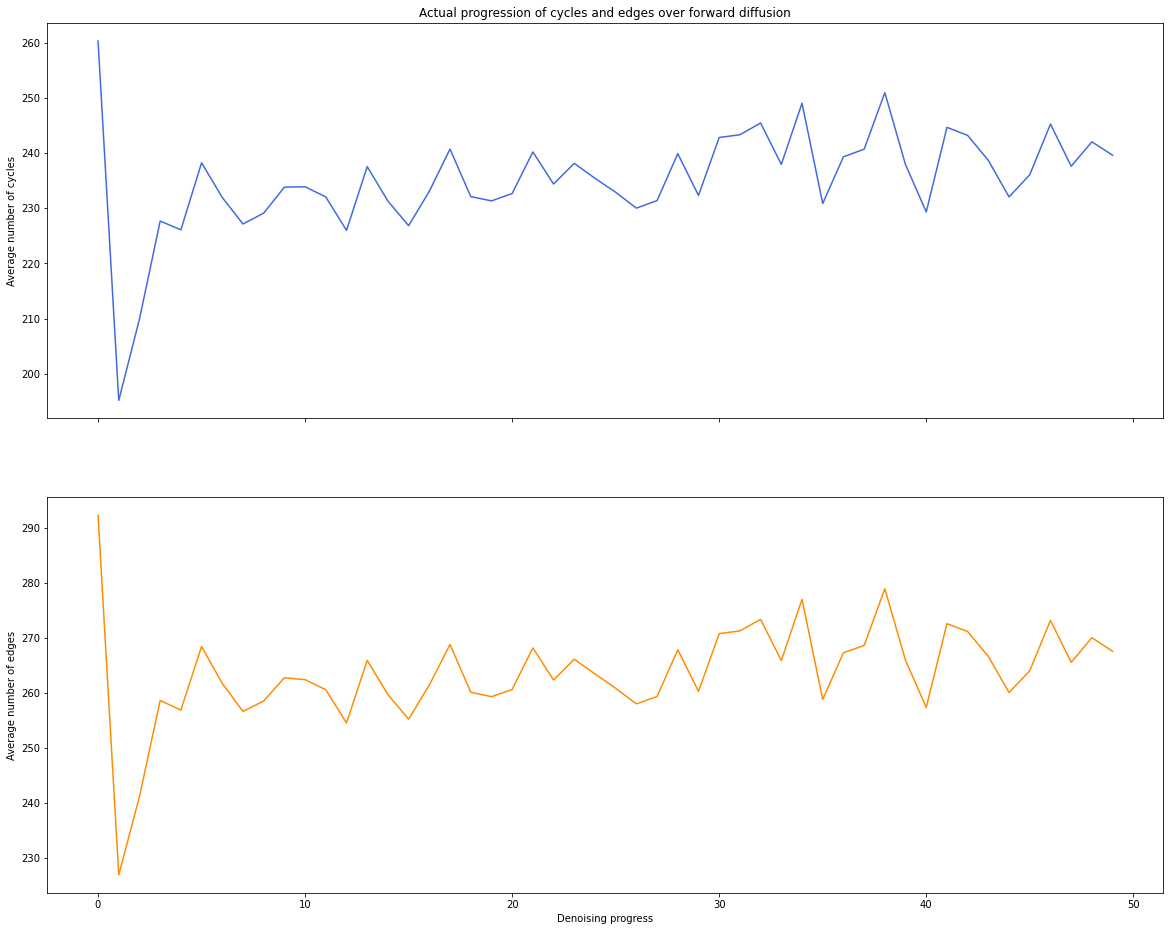

In [20]:
# Check progression of the number of cycles and edges
num_cycles = np.empty((len(graphs), len(graphs[0])))
num_edges = np.empty((len(graphs), len(graphs[0])))
for i in range(len(graphs)):
    for j, g in enumerate(graphs[i]):
        num_cycles[i, j] = len(nx.cycle_basis(g))
        num_edges[i, j] = nx.number_of_edges(g)

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(20, 16))
ax[0].plot(np.arange(len(graphs)), np.mean(num_cycles, axis=1), color="royalblue")
ax[0].set_ylabel("Average number of cycles")

ax[1].plot(np.arange(len(graphs)), np.mean(num_edges, axis=1), color="darkorange")
ax[1].set_ylabel("Average number of edges")
ax[1].set_xlabel("Denoising progress")

ax[0].set_title("Actual progression of cycles and edges over forward diffusion")
plt.show()

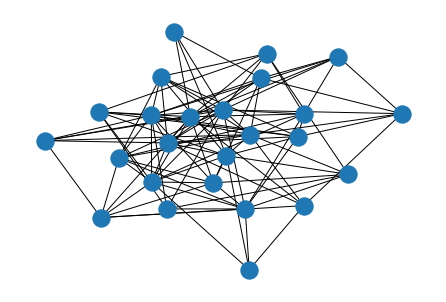

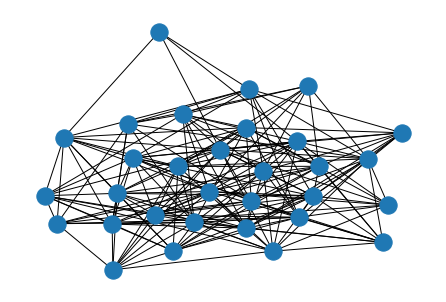

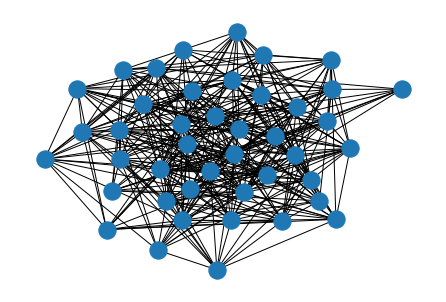

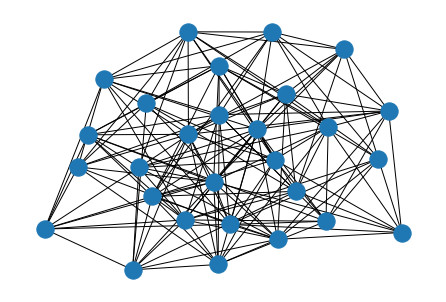

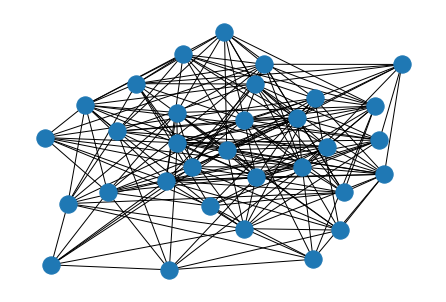

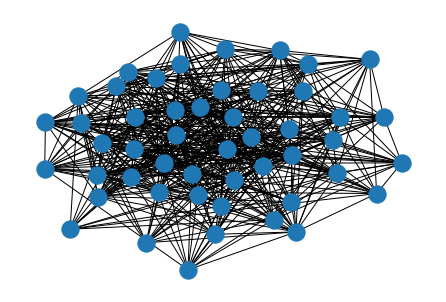

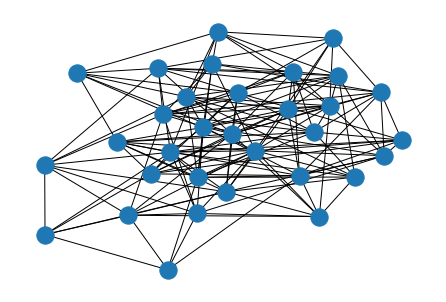

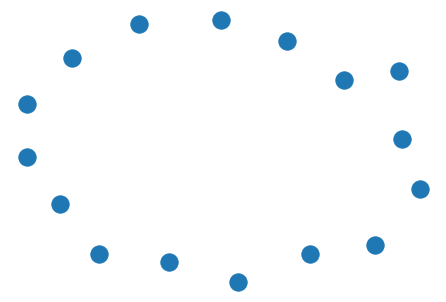

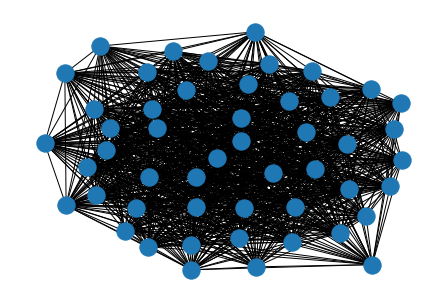

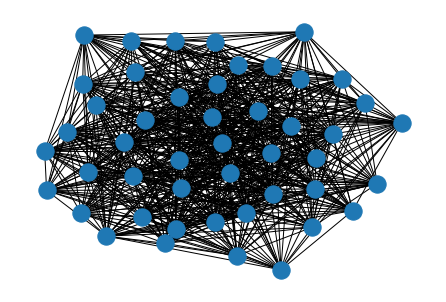

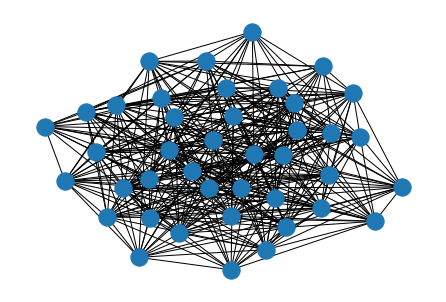

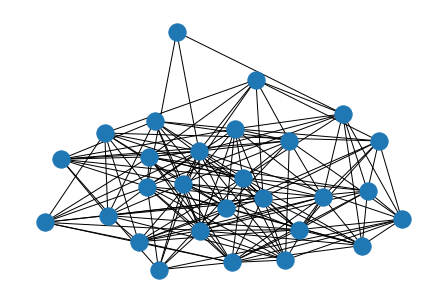

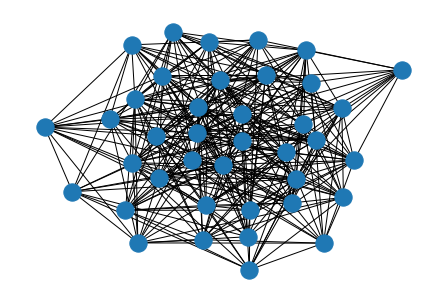

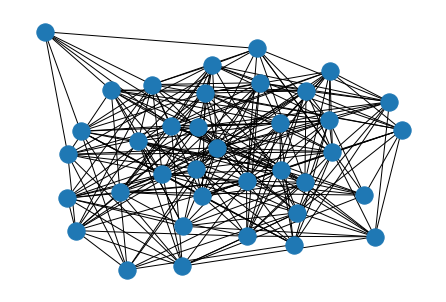

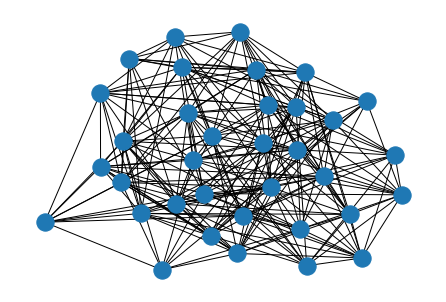

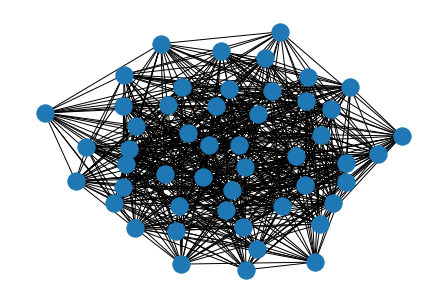

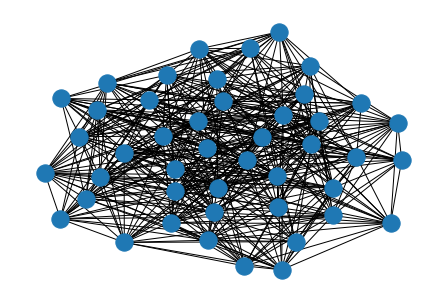

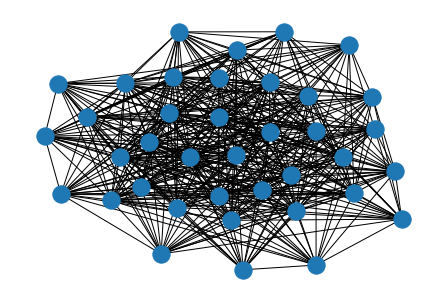

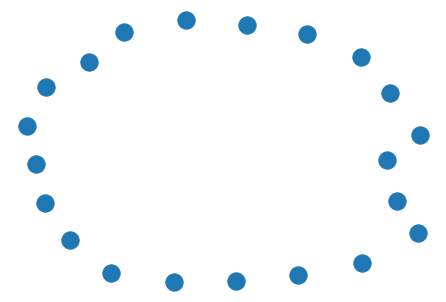

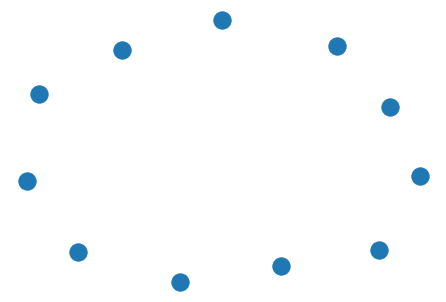

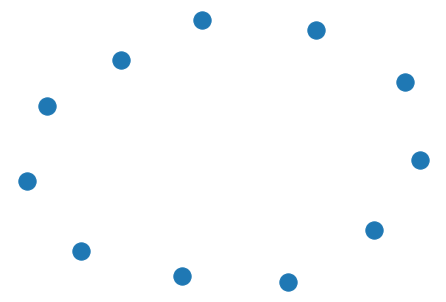

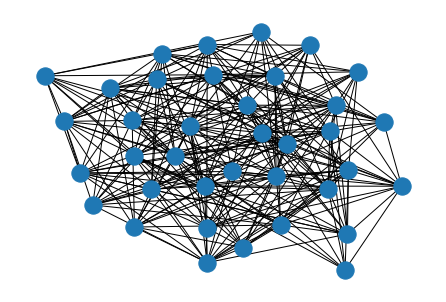

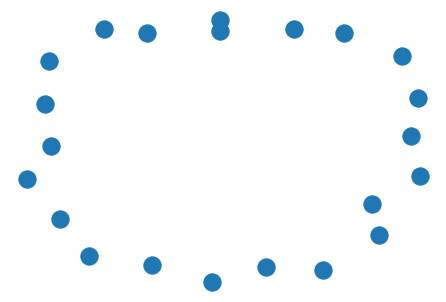

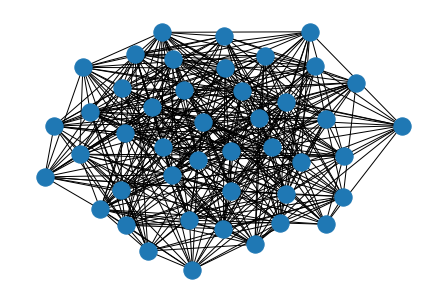

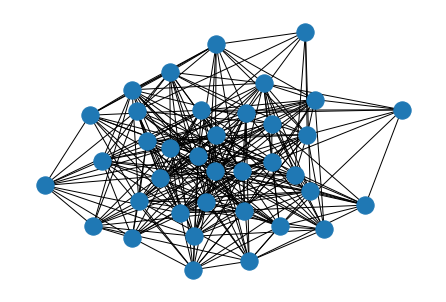

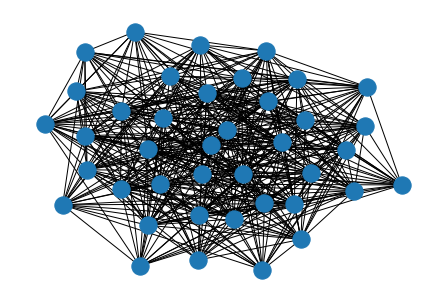

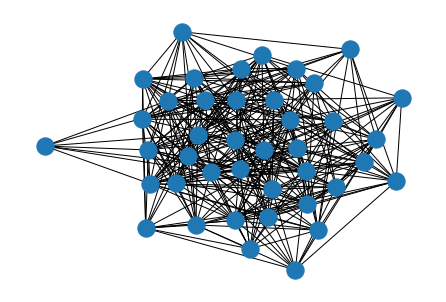

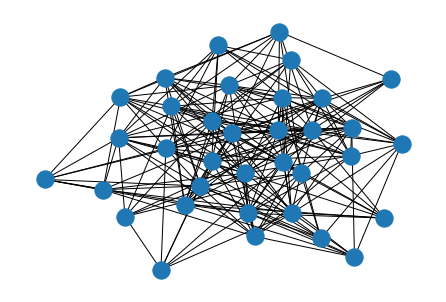

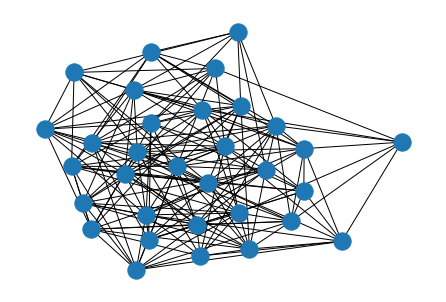

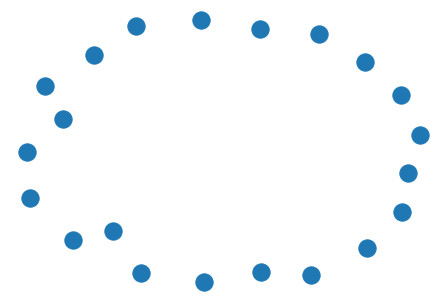

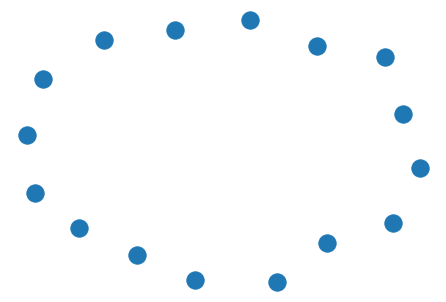

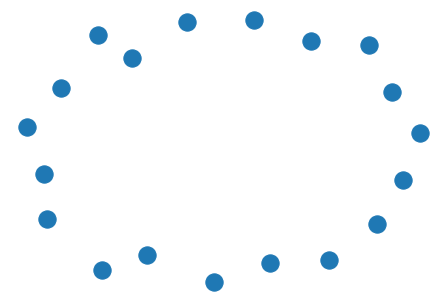

In [23]:
# Plot some randomly generated graphs
for i in np.random.choice(len(graphs[-1]), size=min(32, len(graphs[-1])), replace=False):
    nx.draw(graphs[-1][i])
    plt.show()